In [1]:
import torch
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [3]:
def draw_sphere(xv, yv, zv, center, radius, scale):
    return (((xv-center[0])**2 + (yv-center[1])**2 + (zv-center[2])**2) < radius**2).astype(np.float32) * scale

def draw_cylinder(xv, yv, zv, center, radius, height, scale):
    return scale * ((xv-center[0])**2 + (zv-center[2])**2 < radius**2) * (yv-center[1]<height/2) * (yv-center[1]>-height/2)

In [4]:
x_loc = 0.4*(np.random.uniform(size=10) - 0.5)
y_loc = 0.4*(np.random.uniform(size=10) - 0.5)
z_loc = 0.4*(np.random.uniform(size=10) - 0.5)

In [5]:
xv, yv, zv = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,130), np.linspace(-1,1,150), indexing='ij')
f_theo = draw_cylinder(xv, yv, zv, (0,0,0), 0.5, 1, 0.1) \
        + draw_cylinder(xv, yv, zv, (0.1,-0.4,0), 0.1, 0.5, 0.05) \
        + draw_cylinder(xv, yv, zv, (0.3,0.4,0.2), 0.3, 0.3, 0.1) 
for (x, y, z) in zip(x_loc, y_loc, z_loc):
        f_theo+= draw_cylinder(xv, yv, zv, (x, y, z), 0.3, 0.3, 0.03) 
f = np.random.poisson(f_theo)
f = torch.tensor(f, dtype=torch.float32).to(device)
CT = draw_sphere(xv, yv, zv, (0,0.2,0), 0.5, 1/32)
CT = torch.tensor(CT).to(device)

collimator_slope = 1/20
collimator_intercept = 0

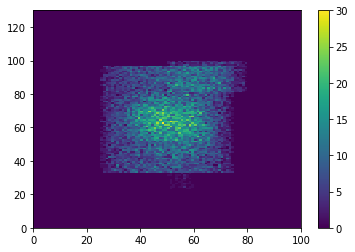

In [6]:
plt.pcolormesh(f.cpu().sum(axis=2).T)
plt.colorbar()

In [7]:
dx = 2 #mm

How to perform forward projection with attenuation

In [8]:
angles = np.arange(0, 360, 3.75)
radii = np.ones(len(angles)) * 150 # mm

Utility functions

In [27]:
def rev_cumsum(x, dim):
    return torch.cumsum(x.flip(dims=(0,)), dim=dim).flip(dims=(0,))

# Rotates in object space around the z-axis
def rotate_z(x, angle, interpolation = InterpolationMode.BILINEAR):
    return rotate(x.permute(2,0,1), angle, interpolation).permute(1,2,0)

Functions for PSF modeling

In [28]:
def get_distance(N, r, dx):
    if N%2==0:
        d = r + (N//2 - np.arange(N)) * dx
    else:
        d = d = r + (N//2 - np.arange(N) - 1/2) * dx
    return d

def get_PSF_transform(FWHM, kernel_size=21, delta=1e-9):
    N = len(FWHM)
    layer = torch.nn.Conv2d(N, N, kernel_size, groups=N, padding='same',
                            padding_mode='replicate', bias=0, device=device)
    x_grid, y_grid = torch.meshgrid(2*[torch.arange(-int(kernel_size//2), int(kernel_size//2)+1)])
    x_grid = x_grid.unsqueeze(dim=0).repeat((100,1,1))
    y_grid = y_grid.unsqueeze(dim=0).repeat((100,1,1))
    FWHM = torch.tensor(FWHM, dtype=torch.float32).reshape((100,1,1))
    kernel = torch.exp(-(x_grid**2 + y_grid**2) / (2*FWHM**2 + delta))
    kernel = kernel / kernel.sum(axis=(1,2)).reshape(100,1,1)
    layer.weight.data = kernel.unsqueeze(dim=1).to(device)
    return layer

@torch.no_grad()
def model_PSF(object, radius, dx, collimator_slope, collimator_intercept):
    distances = get_distance(f.shape[0], radius, dx)
    FWHM = collimator_slope * distances + collimator_intercept
    PSF_transform = get_PSF_transform(FWHM)
    return PSF_transform(object.unsqueeze(dim=0)).squeeze()

def get_prob_of_detection_matrix(CT, dx): 
    return torch.exp(-rev_cumsum(CT* dx, dim=0))

def model_CT(object, prob_of_detection_matrix, dx):
    return object * prob_of_detection_matrix

In [29]:
100 * 500 * 21 * 21 * 8 / 1e9

0.1764

In [30]:
fwhm = np.linspace(3, 5, 100)
get_PSF_transform(fwhm).weight.data.shape

torch.Size([100, 1, 21, 21])

Forward and back projection functions

In [31]:
# c is the diagonal system matrix
# f: [Lx, Ly, Lz], # c: [Lx, Ly, Lz]
def forward_projection(f, CT_options=None, PSF_options = None):
    if CT_options:
        f = model_CT(f, **CT_options)
    if PSF_options:
        f = model_PSF(f, **PSF_options)
    return f.sum(axis=0)

# c is the diagonal system matrix
# g: [Ly, Lz], # c: [Lx, Ly, Lz]
# uses broadcasing rules of numpy/torch
def back_projection(g, width, CT_options=None, PSF_options = None):
    f = g*torch.ones((width, g.shape[0], g.shape[1])).to(device)
    if PSF_options:
        f = model_PSF(f, **PSF_options)
    if CT_options:
        f = model_CT(f, **CT_options)
    return f

def get_forward_projections(f, CT, angles, radii, collimator_slope, collimator_intercept):
    projections = torch.zeros(size=(len(angles), f.shape[1], f.shape[2])).to(device)
    for i, (angle, radius) in enumerate(zip(angles, radii)):
        f_rotated = rotate_z(f, angle)
        CT_rotated = rotate_z(CT, angle)
        c_rotated = get_prob_of_detection_matrix(CT_rotated, dx)
        CT_options = {'prob_of_detection_matrix':c_rotated, 'dx':dx}
        PSF_options = {'radius':radius, 'dx':dx, 'collimator_slope':collimator_slope, 'collimator_intercept':collimator_intercept}
        projections[i] = forward_projection(f_rotated, CT_options, PSF_options)
    return projections

In [32]:
g = get_forward_projections(f, CT, angles, radii, collimator_slope, collimator_intercept)

MLEM with CT Correction Using Pytorch:

Function for next iteraton

In [33]:
def MLEM_iteration(image, object_guess, CT, angles, radii, projection_indices, collimator_slope, collimator_intercept, delta=1e-9):
    N_ij = torch.zeros(size=(image.shape[0], *CT.shape)).to(device)
    c_total = torch.zeros(CT.shape).to(device)
    # Looping through different j's of N_ij (i.e. projections)
    for proj, angle, radius in zip(projection_indices, angles, radii):
        CT_rotated = rotate_z(CT, angle)
        c_rotated = get_prob_of_detection_matrix(CT_rotated, dx)
        object_guess_rotated = rotate_z(object_guess, angle)
        # Options for CT and PSF correction
        CT_options = {'prob_of_detection_matrix':c_rotated, 'dx':dx}
        PSF_options = {'radius':radius, 'dx':dx, 'collimator_slope':collimator_slope, 'collimator_intercept':collimator_intercept}
        # The algorithm
        ratio = image[proj]/(forward_projection(object_guess_rotated, CT_options, PSF_options) + delta)
        N_i_rotated = object_guess_rotated * back_projection(ratio, object_guess.shape[0], CT_options, PSF_options)
        N_i = rotate_z(N_i_rotated, -angle)
        # Append stuff   
        N_ij[proj] = N_i
        c_total += rotate_z(c_rotated, -angle)
    return N_ij.sum(axis=0) / (c_total+delta)

In [34]:
def OSEM(image, object_guess_init, CT, angles, radii, n_subsets, n_iterations, collimator_slope=0, collimator_intercept=0):
    biass = []
    vars = []
    object_guess=object_guess_init
    # Create angle subsets
    angle_subsets = []
    projection_indices_subsets = []
    radius_subsets = []
    for i in range(n_subsets):
        angle_subsets.append(angles[i::n_subsets])
        radius_subsets.append(radii[i::n_subsets])
        projection_indices_subsets.append(np.arange(len(angles))[i::n_subsets])
    # run algorithm
    for i in range(n_iterations):
        for angle_subset, radius_subset, projection_indices in zip(angle_subsets, radius_subsets, projection_indices_subsets):
            object_guess = MLEM_iteration(image, object_guess, CT, angle_subset, radius_subset, projection_indices, collimator_slope, collimator_intercept)
            biass.append(np.mean(f_theo-object_guess.cpu().numpy()))
            vars.append(np.var(f_theo-object_guess.cpu().numpy()))
    return object_guess, biass, vars

In [35]:
object_guess = torch.ones(CT.shape).to(device)
fhat_osem, biass_osem, vars_osem = OSEM(g, object_guess, CT, angles, radii, n_subsets=2, n_iterations=8,
                                        collimator_slope=collimator_slope, collimator_intercept=collimator_intercept)

In [36]:
fhat_mlem, biass_mlem, vars_mlem = OSEM(g, object_guess, CT, angles, radii, n_subsets=1, n_iterations=16,
                                        collimator_slope=collimator_slope, collimator_intercept=collimator_intercept)

Text(0, 0.5, 'Variance')

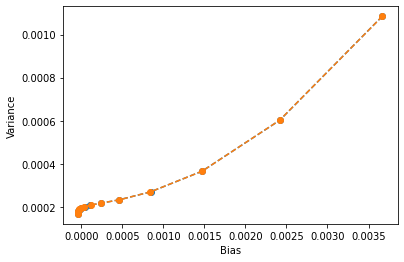

In [37]:
plt.plot(biass_mlem,vars_mlem, 'o--')
plt.plot(biass_osem,vars_osem, 'o--')
plt.xlabel('Bias')
plt.ylabel('Variance')

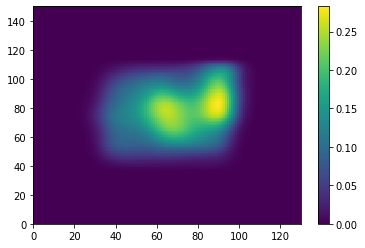

In [38]:
plt.pcolormesh(fhat_mlem.cpu()[65].T)
plt.colorbar()

# Experimenting With PSF Modeling

Blurring of each layer is a function of distance to detector z

In [39]:
g_blurred = model_PSF(f, r=150, dx=0.7, a=0, b=0)

TypeError: model_PSF() got an unexpected keyword argument 'r'

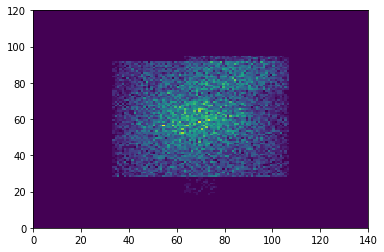

In [ ]:
plt.pcolormesh(g_blurred.detach().cpu())

In [ ]:
kernel_size = 11
layer = torch.nn.Conv3d(1, 1, kernel_size=(128,kernel_size,kernel_size)).to(device)

In [ ]:
layer.weight.data.shape

torch.Size([1, 1, 128, 11, 11])

In [ ]:
layer.weight.data[0][0] = 0
layer.weight.data[0][0][kernel_size//2] = torch.tensor(create_gaussian_kernel(kernel_size, sigma=2))


In [ ]:
layer.weight.data[0][1]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
c= torch.exp(-rev_cumsum(CT * dx, dim=0)).to(device)

In [ ]:
c = torch.zeros((100,130,150)).to(device)
c[:,50:70,50:70] = 1

In [ ]:
c_PSF, net, FWHM = model_PSF_back_projection(c, r=150, dx=2, a=1/70, b=0)


NameError: name 'model_PSF_back_projection' is not defined

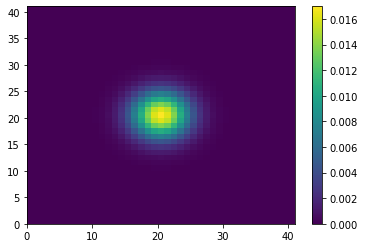

In [ ]:
plt.pcolormesh(net.weight.data[50][0].detach().cpu())
plt.colorbar()

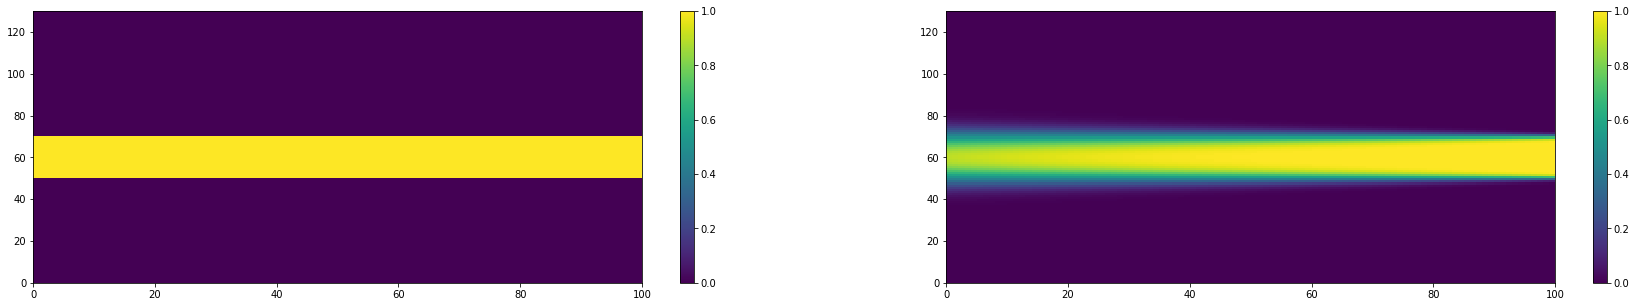

In [ ]:
plt.subplots(1,2,figsize=(30,5))
plt.subplot(121)
plt.pcolormesh(c[:,:,60].cpu().T)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(c_PSF[:,:,60].detach().cpu().T)
plt.colorbar()


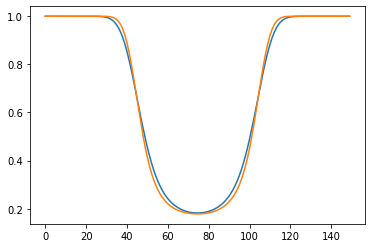

In [ ]:
plt.plot(c_PSF[0,60].detach().cpu())
plt.plot(c_PSF[30,60].detach().cpu())

# Experimenting With Class 